In [1]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import AdvectionSolvers

# Solve Advection part from Vlasov Equation

Model:
$$\frac{\partial f}{\partial t} + v \frac{\partial f}{\partial x} - E\frac{\partial f}{\partial v} = 0 $$
Solve the differential equation by the splitting method

Splitting Method

Step 1: Solve the advection equation in the velocity space

$$ (A): \frac{\partial f^*}{\partial t} - E\frac{\partial f^*}{\partial v} = 0 \\
f^*(t_n) = f(t_n)$$

Step 2: Solve the advection equation in the positions space

$$ (B): \frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} = 0 \\
f(t_n) = f^*(t_{n+1})$$

#### First order splitting:

$$ \frac{d}{dt}u = F u $$
$F$ can be split into $F_1$ and $F_2$. So we have:
$$ \frac{d}{dt}u = (F_1 + F_2) u $$

Let $u_n \approx u(t_n)$
$$ \frac{d}{dt}u^* = F_1(t,u^*(t)) \space \space \space \space for \space \space t_n<t\leq t_{n+1}, \space \space u^*(t_n)=u_n $$
$$ \frac{d}{dt}u^{**} = F_2(t,u^{**}(t)) \space \space \space \space for \space \space t_n<t\leq t_{n+1}, \space \space u^{**}(t_n)=u^*(t_{n+1}) $$
$$ u_{n+1} = u^{**}(t_{n+1})  $$

In [2]:
# Define variables
L_x = 12 # Longitude
v_min = -5 # Minimum Velocity
v_max = 5 # Maximum Velocity
T_max = 30 # Max time

sigma = 1.2 # Standard Deviation

Initial Condition:

$$ f(x,v,t=0) =  \frac{1}{2\pi\sigma^2} \exp \Big(\frac{-(x - L/2)^2}{2\sigma^2}\Big)\exp\Big(-\frac{v^2}{2\sigma^2}\Big)$$

In [3]:
# Initial Condition
def initial_cond(x,v):
    return  (1.0/(2.0*np.pi*sigma**2))* np.exp(-(x - L_x/2)**2/ (2*sigma**2)) * np.exp(-v**2/(2*sigma**2))

In [4]:
def error_func(y1,y2):
    '''Calculate the difference between to arrays'''
    y1 = np.array(y1)
    y2 = np.array(y2)
    if np.array(y1).shape == np.array(y2).shape:
        diff = y1-y2
        return diff
    else:
        print('Arrays must have the same dimension')

In [5]:
def calculate_norm(vector,norm_number):
    '''vector: Array or vector to which you want to determine the norm: 1,2 or inf
       norm_number: Norm order'''
    if type(norm_number) == str:
        return np.linalg.norm(vector,ord = float(norm_number))
    else:
        return np.linalg.norm(vector , ord = norm_number)

In [6]:
# General Solution to the advection equation:
def general_solution(x,vel,v,acc,t):
    ''' General Solution of Advection in 2 dimensions with L_x and v_max-v_min periodicity
        x: Position vector 
        vel: Position advection coefficient (Same shape as v)
        v: Velocities vector
        acc: Velocities advection coefficient (Same Shape as x)
        t: Time Displacement '''
    
    X, V = np.meshgrid(x,v)
    Acc,Vel = np.meshgrid(acc,vel)
    
    X_dis = (X - Vel*t)%(L_x) # Displacement with L_x periodicity
    V_dis = (V - Acc*t - v_min)%(v_max - v_min) + v_min # Displacement with (v_max - v_min) periodicity
    
    return X,V,initial_cond(X_dis,V_dis)

In [7]:
def analytical_solution(x,a,v,tt):
    '''Analytical solution by advection in the velocities direction. x is a point in the 2D space, a is the advection
    coefficient, v is the velocity vector, tt is the time displaced'''
    
    return initial_cond( x , ((v - a*tt - v_min)%(v_max-v_min) + v_min))

In [8]:
def analytical_solution2(x,a,v,tt):
    '''Analytical solution by advection in the position direction. x is the positions vector, a is the advection
    coefficient, v is a point in the 2D space, tt is the time displaced'''
    
    return initial_cond( ((x - a*tt)%(L_x)) , v )

## Test the advection solvers in 2 dimensions using the Splitting Method

In [9]:
N_x = 128
N_y = 128
T_size = 1500
dx = L_x/N_x
dv = (v_max-v_min)/N_y
dt = T_max/T_size

positions = np.arange(0,L_x + dx,dx)
velocities = np.arange(v_min,v_max + dv ,dv)

print(positions.shape)
print(velocities.shape)

print('dx: ',dx)
print('dv: ',dv)
print('dt: ',dt)

(129,)
(129,)
dx:  0.09375
dv:  0.078125
dt:  0.02


In [10]:
# Constant X advection vector
e_fconst = np.ones(positions.shape) * 3.8
print('CFL parameter in x:', e_fconst[0]*dt/dv)

# Constant V advection vector
vel_adv = np.ones(velocities.shape) * 4.5
print('CFL parameter in v:', vel_adv[0]*dt/dx)

CFL parameter in x: 0.9728
CFL parameter in v: 0.96


In [11]:
# Initial Condition:
Pos, Vel = np.meshgrid(positions, velocities)
Z_init = initial_cond(Pos,Vel)

### Lax Scheme 2D

In [12]:
# Create Object 
objLax = AdvectionSolvers.Advection_Methods_2D(initial_cond, 0, L_x, N_x, v_min, v_max, N_y, T_max, T_size, e_fconst,
                                              vel_adv, 'Lax Wendroff', 1, 'Advection2DLax')

In [13]:
mass,norml2 = objLax.run_iteration() # Run simulation

In [14]:
data_AdvLax = np.loadtxt("Advection2DLax.txt") # Open file
data_AdvLax = data_AdvLax.reshape(T_size + 1 , N_y + 1 , N_x + 1) # Reshape flat array
data_AdvLax.shape

(1501, 129, 129)

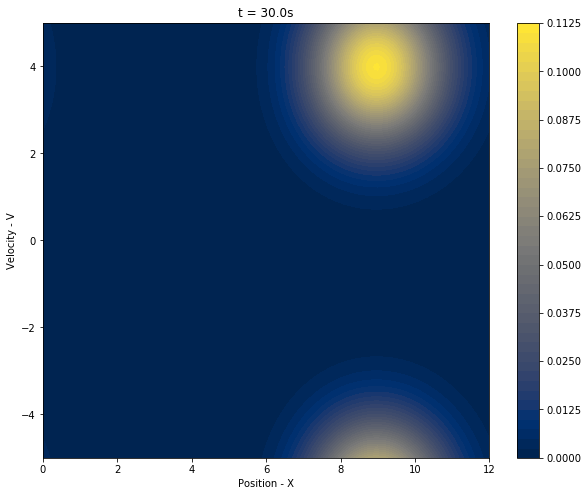

In [15]:
fig,ax=plt.subplots(1,1,figsize = (10, 8))
cp = ax.contourf(Pos, Vel , data_AdvLax[-1],50, cmap = cm.cividis)
fig.colorbar(cp) # Add a colorbar to a plot

plt.title(f't = {T_size*dt}s')
ax.set_xlabel('Position - X')
ax.set_ylabel('Velocity - V')

plt.show()

#### Calculate the error of the Lax Wendroff Scheme:

In [16]:
times = objLax.grid_points(0,T_max,dt)

In [17]:
errorsLax = []
for i in range(T_size+1):
    XX,VV,Z_analytical = general_solution(positions, vel_adv, velocities, e_fconst, times[i])
    norm = np.linalg.norm(Z_analytical - data_AdvLax[i] , ord = 2) 
    errorsLax.append(norm)

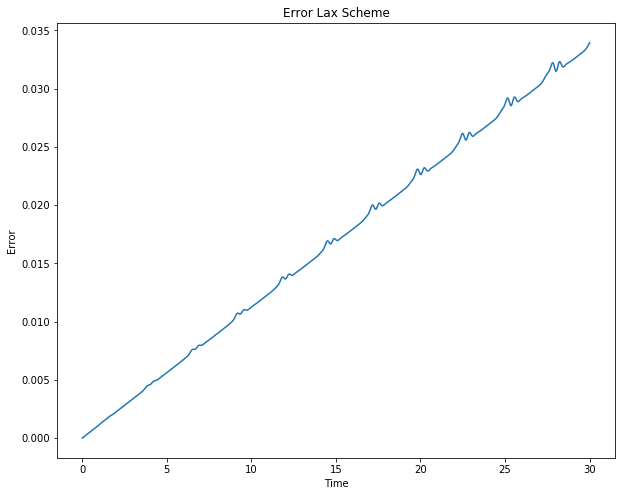

In [18]:
plt.figure(figsize=(10,8))
plt.title('Error Lax Scheme')
plt.plot(times,errorsLax)
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

### Spectral Scheme 2D

In [19]:
# Create Object 
objSpec = AdvectionSolvers.Advection_Methods_2D(initial_cond, 0, L_x, N_x, v_min, v_max, N_y, T_max, T_size, e_fconst,
                                              vel_adv, 'Spectral', 1, 'Advection2DSpectral')

In [20]:
mass2,norml22 = objSpec.run_iteration() # Run simulation

In [21]:
data_AdvSpec = np.loadtxt("Advection2DSpectral.txt") # Open file
data_AdvSpec = data_AdvSpec.reshape(T_size + 1 , N_y + 1 , N_x + 1) # Reshape flat array
data_AdvSpec.shape

(1501, 129, 129)

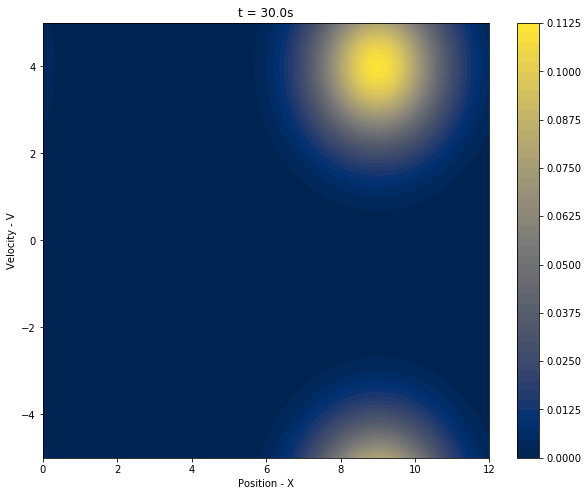

In [22]:
fig,ax=plt.subplots(1,1,figsize = (10, 8))
cp = ax.contourf(Pos, Vel , data_AdvSpec[-1],50, cmap = cm.cividis)
fig.colorbar(cp) # Add a colorbar to a plot

plt.title(f't = {T_size*dt}s')
ax.set_xlabel('Position - X')
ax.set_ylabel('Velocity - V')

plt.show()

#### Calculate the error of the Spectral Scheme:

In [23]:
errorsSpec = []
for i in range(T_size+1):
    XX,VV,Z_analytical = general_solution(positions, vel_adv, velocities, e_fconst, times[i])
    norm = np.linalg.norm(Z_analytical - data_AdvSpec[i] , ord = 2) 
    errorsSpec.append(norm)

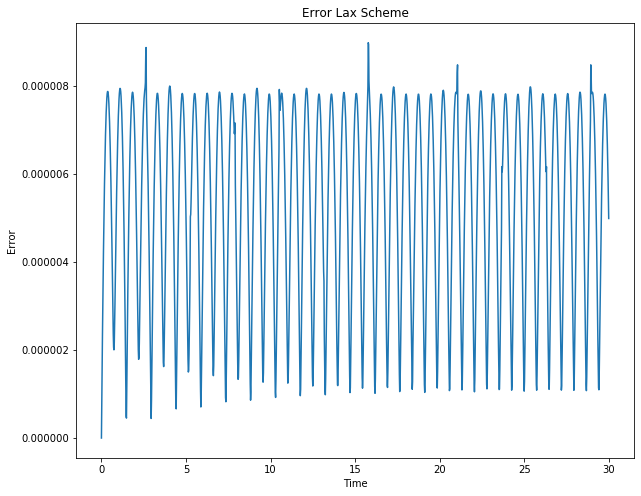

In [24]:
plt.figure(figsize=(10,8))
plt.title('Error Lax Scheme')
plt.plot(times,errorsSpec)
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

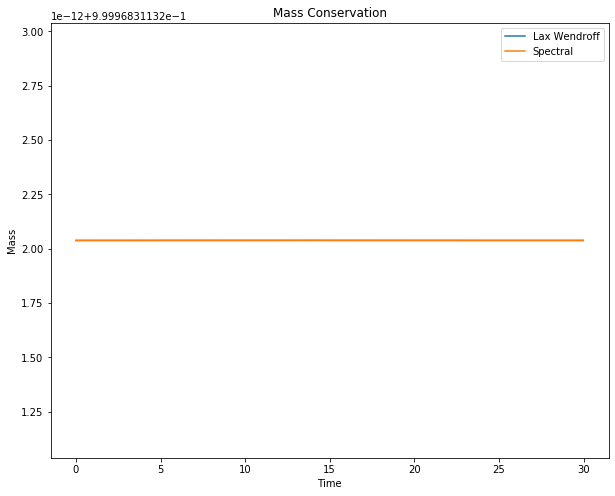

In [25]:
plt.figure(figsize=(10,8))
plt.title('Mass Conservation')
plt.plot(times[:-1],mass , label = 'Lax Wendroff')
plt.plot(times[:-1],mass2,label = 'Spectral')
plt.xlabel('Time')
plt.ylabel('Mass')
plt.legend()
plt.show()

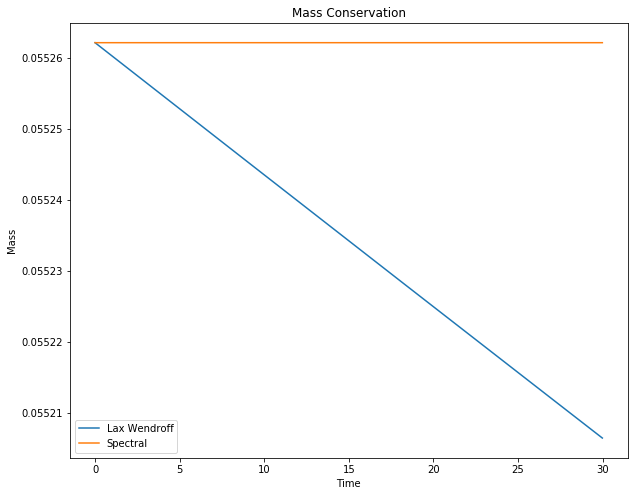

In [26]:
plt.figure(figsize=(10,8))
plt.title('Mass Conservation')
plt.plot(times[:-1],norml2 , label = 'Lax Wendroff')
plt.plot(times[:-1],norml22,label = 'Spectral')
plt.xlabel('Time')
plt.ylabel('Mass')
plt.legend()
plt.show()

In [27]:
import matplotlib.animation as animation
from IPython import display

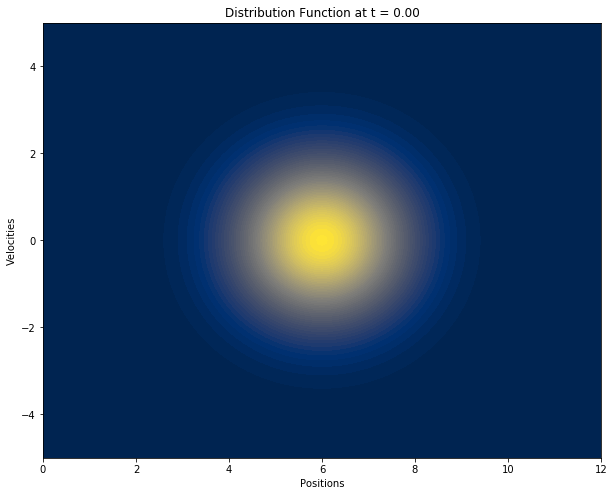

In [29]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg'] 
writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=(0, L_x), ylim=(v_min, v_max))
plt.xlabel('Positions')
plt.ylabel('Velocities')

def animation_frame(i):

    z = data_AdvSpec[i]
    cont = plt.contourf(Pos, Vel, z, 60 , cmap = cm.cividis)
    plt.title('Distribution Function at t = '+ "%.2f"%times[i])
    
    return cont,

ani = animation.FuncAnimation(fig , func = animation_frame,frames = np.array(list(range(0,T_size+1,10))),interval = 100)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)